Crime analysis, Hotspot Classification and Forcasting in South Africa

Student Number: 22433510
Surname and Initials: Ngubane S.K

Project Overview
Crime in South Africa is one of the country's most critical social and economic challenges.
This project aims to apply Machine Learning and data analysis techniques to identify crime hotspots and forecast crime future trends using officila crime statistics from South African Police Service(SAPS).

Two main objectives:
1. Classification of crime hotspots - Predict which police precincts qualify as a crime hotspots(top 25% with highest incidents).
2. Forecasting cime trends over time - Forecast future trends for selected crime categories(e.g burglary, assault, vehicle theft) to help law enforcement plan better inetrvantions.



*   https://www.kaggle.com/datasets
*   



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from prophet import Prophet


In [16]:
CrimeStat = pd.read_csv('/content/drive/MyDrive/SouthAfricaCrimeStats_v2.csv')
Sample1 = pd.read_csv('/content/drive/MyDrive/Census2022sample_F18.csv')
Sample2= pd.read_csv('/content/drive/MyDrive/Census2022sample_F19.csv')
Sample3= pd.read_csv('/content/drive/MyDrive/Census2022sample_F21.csv')
print("Datasets loaded!")
print(CrimeStat.head())

Datasets loaded!
       Province            Station                           Category  \
0  Western Cape  Cape Town Central  All theft not mentioned elsewhere   
1       Gauteng        Jhb Central  All theft not mentioned elsewhere   
2  Western Cape    Mitchells Plain  All theft not mentioned elsewhere   
3    Free State          Park Road  All theft not mentioned elsewhere   
4       Gauteng   Pretoria Central  All theft not mentioned elsewhere   

   2005-2006  2006-2007  2007-2008  2008-2009  2009-2010  2010-2011  \
0       6692       6341       5966       5187       4985       5127   
1       6093       4602       3761       3610       3267       3037   
2       5341       6093       6316       6803       6035       5761   
3       5108       4282       3834       3316       3101       3013   
4       5099       4536       3309       2694       2616       2606   

   2011-2012  2012-2013  2013-2014  2014-2015  2015-2016  
0       5285       5937       5600       5335       5176  

In [41]:
Sample1.head(4)

,QID,Province,District,Municipality,Geo_type
0,10000003,1,CPT,CPT,1
1,10000005,1,CPT,CPT,1
2,10000008,1,DC4,WC043,1
3,10000018,1,CPT,CPT,1


In [42]:
Sample2.head(4)

,QID,DERH_HSIZE,DERH_HHSEX,DERH_HHPOP,DERH_HHAGE,H01_QUARTERS,H02_MAINDWELLING,H03_TENURE,H04_RDP,H05_WATERPIPED,...,H12_DVD_PLAYER,H12_MOTOR_CAR,H12_TELEVISION,H12_RADIO,H12_LANDLINE,H12_CELLPHONE,H13_INTERNET_ACCESS,A4_ADULT_HUNGER,A5_CHILD_HUNGER,HH_WGT
0,10000003,2,2,1,44,5,1.0,8.0,8.0,3,...,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,15.584189
1,10000005,4,2,1,41,5,1.0,8.0,8.0,1,...,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,15.584189
2,10000008,3,1,2,76,1,1.0,4.0,2.0,1,...,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,15.578663
3,10000018,2,2,1,37,1,1.0,4.0,2.0,1,...,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,15.584189


In [43]:
Sample3.head(4)

,QID,PID,P02_SEX,P03_YEAR,P03_MONTH,AGE_GROUP,P04_AGE,P05_RELATION,P06_MARITAL_ST,P07A_POP_GROUP,...,P17D_DEVMEDWHEELCHAIR,P17F_DEVMED_OTHER,DISABILITY_STATUS,P18A_MOTHERALIVE,P18B_FATHERALIVE,P19_ECD_ATTENDANCE,P20_EDUINST,P21_EDULEVEL,P22_EDUFIELD,PERS_WGT
0,10000003,10000003001,2,1977,8.0,3.0,44,1.0,6.0,1,...,2.0,2.0,0.0,2.0,2.0,8.0,1.0,12.0,8.0,21.567356
1,10000003,10000003002,2,2004,8.0,4.0,17,3.0,6.0,1,...,2.0,2.0,0.0,1.0,1.0,8.0,4.0,10.0,8.0,18.902319
2,10000005,10000005001,2,1980,3.0,3.0,41,1.0,1.0,1,...,2.0,2.0,0.0,2.0,2.0,8.0,1.0,24.0,10.0,21.567356
3,10000005,10000005002,1,1978,3.0,3.0,43,2.0,1.0,1,...,2.0,2.0,0.0,2.0,2.0,8.0,6.0,28.0,26.0,23.281103


In [44]:
CrimeStat = CrimeStat.drop_duplicates()

In [47]:
# Melt the DataFrame to transform year columns into rows
CrimeStat_melted = CrimeStat.melt(id_vars=['Province', 'Station', 'Category'],
                                  var_name='Year',
                                  value_name='Incident_Count')

In [48]:
# Convert the 'Year' column to datetime objects.
# We will use the start year of the range for simplicity.
CrimeStat_melted['Year'] = CrimeStat_melted['Year'].apply(lambda x: pd.to_datetime(x.split('-')[0]))

In [49]:
# Display the first few rows of the melted DataFrame
display(CrimeStat_melted.head())

,Province,Station,Category,Year,Incident_Count
0,Western Cape,Cape Town Central,All theft not mentioned elsewhere,2005-01-01,6692
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,2005-01-01,6093
2,Western Cape,Mitchells Plain,All theft not mentioned elsewhere,2005-01-01,5341
3,Free State,Park Road,All theft not mentioned elsewhere,2005-01-01,5108
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,2005-01-01,5099


In [50]:
print(CrimeStat.isnull().sum()) # Check missing values
CrimeStat.fillna(0, inplace=True)


Province     0
Station      0
Category     0
2005-2006    0
2006-2007    0
2007-2008    0
2008-2009    0
2009-2010    0
2010-2011    0
2011-2012    0
2012-2013    0
2013-2014    0
2014-2015    0
2015-2016    0
dtype: int64


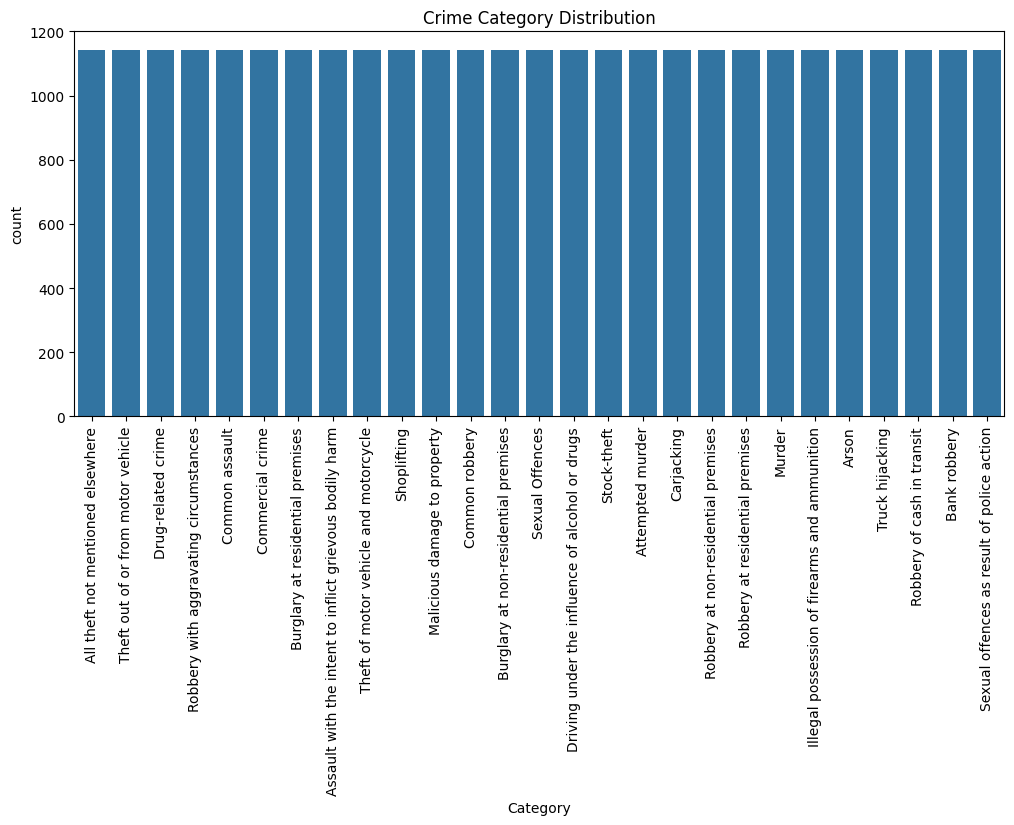

In [51]:
plt.figure(figsize=(12,5))
sns.countplot(x='Category', data=CrimeStat)
plt.title("Crime Category Distribution")
plt.xticks(rotation=90)
plt.show()

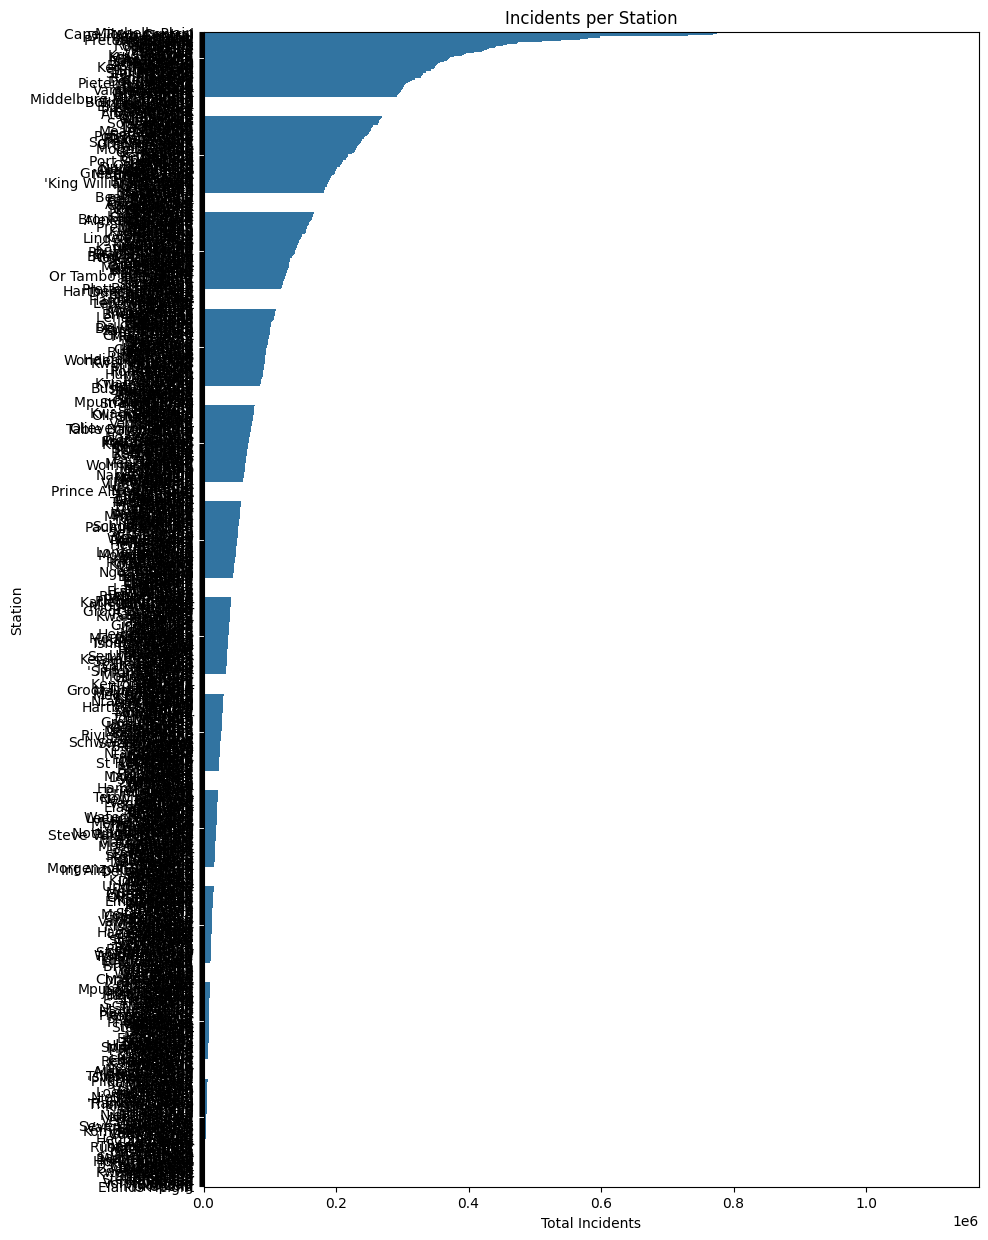

In [56]:
# Sum incident counts across all year columns for each station
CrimeStat['Total_Incidents'] = CrimeStat.iloc[:, 3:].sum(axis=1)

precinct_counts = CrimeStat.groupby('Station')['Total_Incidents'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) # Increased figure height for horizontal plot
sns.barplot(x=precinct_counts.values, y=precinct_counts.index) # Swapped x and y for horizontal plot
plt.title('Incidents per Station')
plt.xlabel('Total Incidents') # Swapped x and y labels
plt.ylabel('Station')
plt.show()

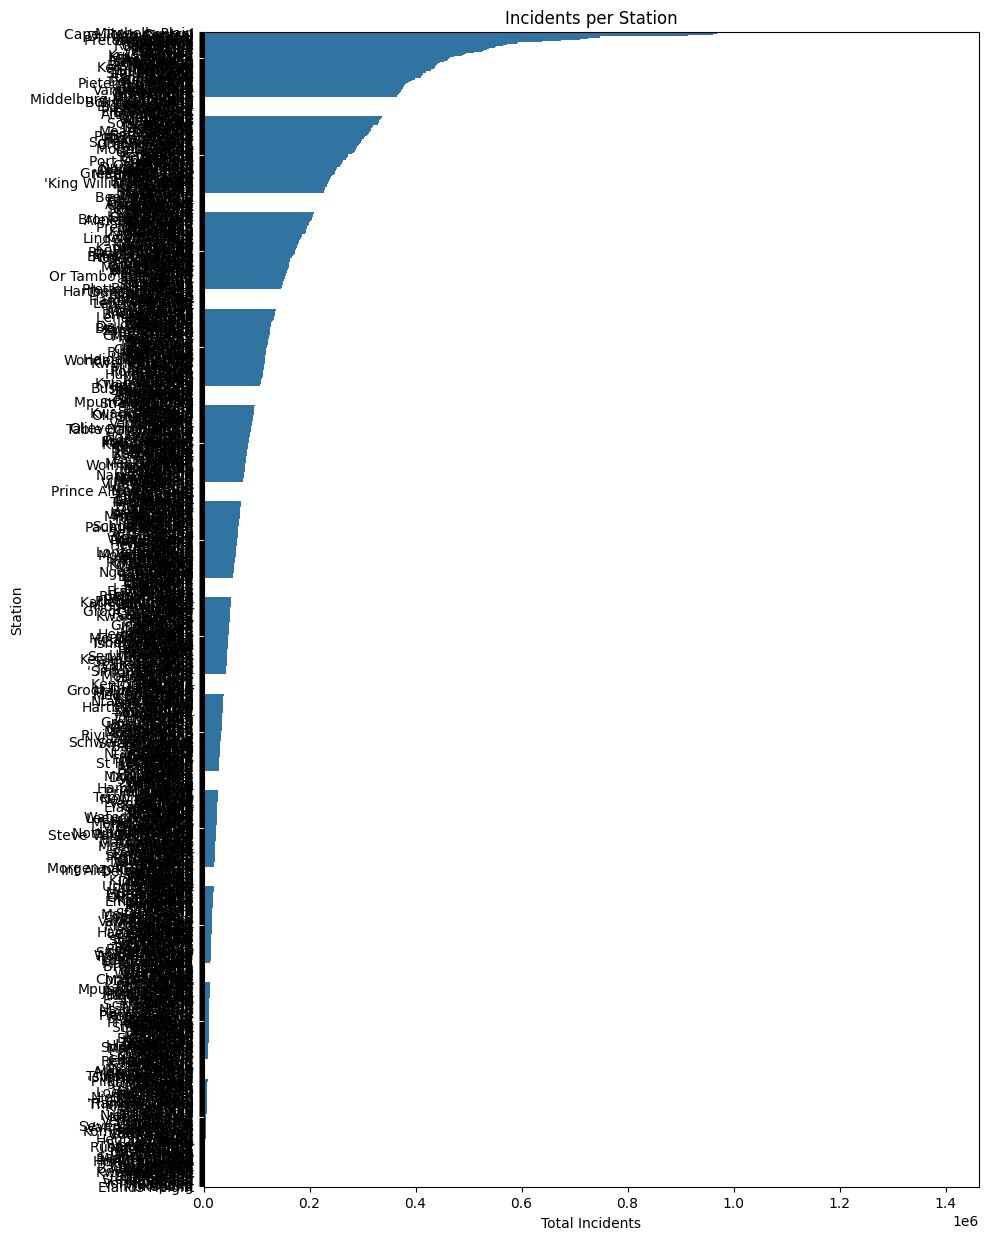

In [57]:
# Sum incident counts across all year columns for each station
CrimeStat['Total_Incidents'] = CrimeStat.iloc[:, 3:].sum(axis=1)

precinct_counts = CrimeStat.groupby('Station')['Total_Incidents'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) # Increased figure height for horizontal plot
sns.barplot(x=precinct_counts.values, y=precinct_counts.index) # Swapped x and y for horizontal plot
plt.title('Incidents per Station')
plt.xlabel('Total Incidents') # Swapped x and y labels
plt.ylabel('Station')
plt.show()

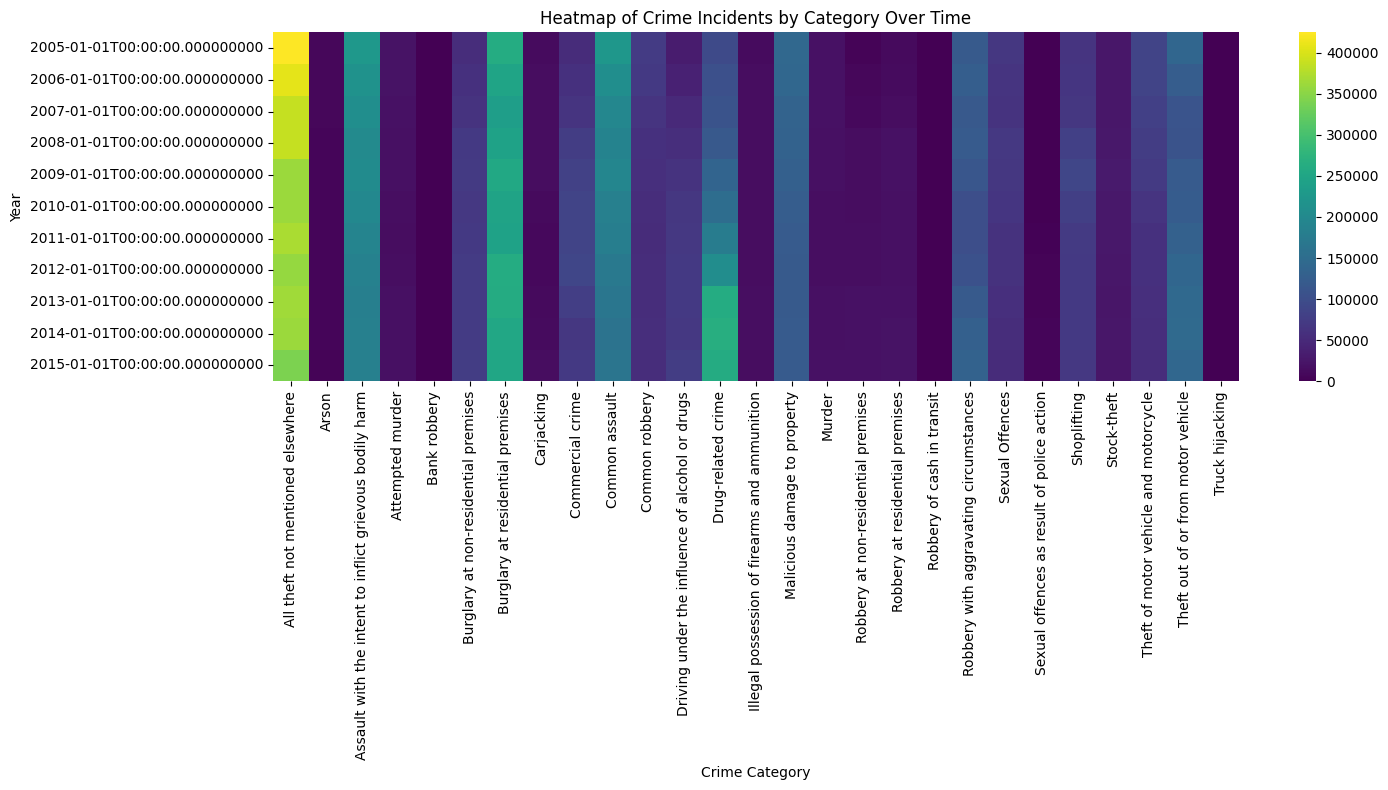

In [52]:
# Create a pivot table for the heatmap
heatmap_data = CrimeStat_melted.pivot_table(index='Year', columns='Category', values='Incident_Count', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=False) # annot=False for readability with many categories
plt.title('Heatmap of Crime Incidents by Category Over Time')
plt.xlabel('Crime Category')
plt.ylabel('Year')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Task
Clean the `Sample_1`, `Sample_2`, `Sample_3`, and `Sample_4` DataFrames by checking for and handling missing values and inconsistencies.

## Check for missing values

### Subtask:
Identify columns with missing values in each of the `Sample` DataFrames.


**Reasoning**:
Check for missing values in Sample1, Sample2, and Sample3 DataFrames.



In [24]:
print("Missing values in Sample1:")
print(Sample1.isnull().sum())
print("\nMissing values in Sample2:")
print(Sample2.isnull().sum())
print("\nMissing values in Sample3:")
print(Sample3.isnull().sum())

Missing values in Sample1:
QID             0
Province        0
District        0
Municipality    0
Geo_type        0
dtype: int64

Missing values in Sample2:
QID                       0
DERH_HSIZE                0
DERH_HHSEX                0
DERH_HHPOP                0
DERH_HHAGE                0
H01_QUARTERS              0
H02_MAINDWELLING          0
H03_TENURE                0
H04_RDP                   0
H05_WATERPIPED            0
H06_WATERSOURCE           0
H07A_WATERSUPPLY          0
H08_TOILET                0
H09_ENERGY_COOKING        0
H10_ENERGY_LIGHTING       0
H11_REFUSE                0
H12_REFRIGERATOR          0
H12_ELECTRIC_GAS_STOVE    0
H12_VACUUM_CLEANER        0
H12_WASHINGM              0
H12_COMPUTER              0
H12_SATELLITE             0
H12_DVD_PLAYER            0
H12_MOTOR_CAR             0
H12_TELEVISION            0
H12_RADIO                 0
H12_LANDLINE              0
H12_CELLPHONE             0
H13_INTERNET_ACCESS       0
A4_ADULT_HUNGER           0
A5

## Handle missing values

### Subtask:
Determine appropriate strategies for handling missing values (e.g., imputation, removal) based on the nature and extent of the missing data in each column.


## Check for inconsistencies

### Subtask:
Examine the data for inconsistencies, such as incorrect data types, outlier values, or illogical entries.


**Reasoning**:
Print the data types and descriptive statistics for Sample1, Sample2, and Sample3 DataFrames and examine unique values for categorical columns to identify inconsistencies and outliers.



In [25]:
print("Sample1 Info:")
Sample1.info()
print("\nSample2 Info:")
Sample2.info()
print("\nSample3 Info:")
Sample3.info()

print("\nSample1 Descriptive Statistics:")
display(Sample1.describe())
print("\nSample2 Descriptive Statistics:")
display(Sample2.describe())
print("\nSample3 Descriptive Statistics:")
display(Sample3.describe())

print("\nSample1 Unique Values for Categorical Columns:")
for col in ['Province', 'District', 'Municipality', 'Geo_type']:
    print(f"\nUnique values in {col}:")
    print(Sample1[col].unique())

print("\nSample2 Unique Values for Categorical Columns:")
for col in ['DERH_HHSEX', 'H01_QUARTERS', 'H02_MAINDWELLING', 'H03_TENURE', 'H04_RDP', 'H05_WATERPIPED', 'H12_DVD_PLAYER', 'H12_MOTOR_CAR', 'H12_TELEVISION', 'H12_RADIO', 'H12_LANDLINE', 'H12_CELLPHONE', 'H13_INTERNET_ACCESS', 'A4_ADULT_HUNGER', 'A5_CHILD_HUNGER']:
    print(f"\nUnique values in {col}:")
    print(Sample2[col].unique())

print("\nSample3 Unique Values for Categorical Columns:")
for col in ['P02_SEX', 'P03_MONTH', 'AGE_GROUP', 'P05_RELATION', 'P06_MARITAL_ST', 'P07A_POP_GROUP', 'P17D_DEVMEDWHEELCHAIR', 'P17F_DEVMED_OTHER', 'DISABILITY_STATUS', 'P18A_MOTHERALIVE', 'P18B_FATHERALIVE', 'P19_ECD_ATTENDANCE', 'P20_EDUINST', 'P21_EDULEVEL', 'P22_EDUFIELD']:
     print(f"\nUnique values in {col}:")
     print(Sample3[col].unique())

Sample1 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338295 entries, 0 to 1338294
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   QID           1338295 non-null  int64 
 1   Province      1338295 non-null  int64 
 2   District      1338295 non-null  object
 3   Municipality  1338295 non-null  object
 4   Geo_type      1338295 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 51.1+ MB

Sample2 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338295 entries, 0 to 1338294
Data columns (total 32 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   QID                     1338295 non-null  int64  
 1   DERH_HSIZE              1338295 non-null  int64  
 2   DERH_HHSEX              1338295 non-null  int64  
 3   DERH_HHPOP              1338295 non-null  int64  
 4   DERH_HHAGE              1338295 non-null  int64  
 5

,QID,Province,Geo_type
count,1.338295e+06,1.338295e+06,1.338295e+06
mean,5.441880e+07,5.374965e+00,1.382064e+00
std,2.541801e+07,2.541530e+00,5.570827e-01
min,1.000000e+07,1.000000e+00,1.000000e+00
25%,4.000449e+07,4.000000e+00,1.000000e+00
50%,6.053963e+07,6.000000e+00,1.000000e+00
75%,7.101233e+07,7.000000e+00,2.000000e+00
max,9.133829e+07,9.000000e+00,3.000000e+00



Sample2 Descriptive Statistics:


,QID,DERH_HSIZE,DERH_HHSEX,DERH_HHPOP,DERH_HHAGE,H01_QUARTERS,H02_MAINDWELLING,H03_TENURE,H04_RDP,H05_WATERPIPED,...,H12_DVD_PLAYER,H12_MOTOR_CAR,H12_TELEVISION,H12_RADIO,H12_LANDLINE,H12_CELLPHONE,H13_INTERNET_ACCESS,A4_ADULT_HUNGER,A5_CHILD_HUNGER,HH_WGT
count,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,...,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06,1.338295e+06
mean,5.441880e+07,3.130250e+00,1.499919e+00,1.457824e+00,4.665343e+01,1.303434e+00,8.391865e+00,5.067020e+00,3.648719e+00,2.154316e+00,...,3.150651e+00,3.179162e+00,2.793041e+00,3.013674e+00,3.366707e+00,2.676414e+00,2.288776e+01,3.061509e+00,3.331753e+00,1.438706e+01
std,2.541801e+07,2.095602e+00,5.000002e-01,9.782751e-01,1.510927e+01,1.027837e+00,2.266890e+01,2.592156e+00,3.168044e+00,1.878053e+00,...,2.966784e+00,2.950606e+00,3.139068e+00,3.038948e+00,2.835685e+00,3.184382e+00,3.830731e+01,3.143941e+00,3.199039e+00,3.093129e+00
min,1.000000e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.147002e+01
25%,4.000449e+07,1.000000e+00,1.000000e+00,1.000000e+00,3.600000e+01,1.000000e+00,1.000000e+00,4.000000e+00,2.000000e+00,1.000000e+00,...,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.189121e+01
50%,6.053963e+07,3.000000e+00,1.000000e+00,1.000000e+00,4.600000e+01,1.000000e+00,1.000000e+00,4.000000e+00,2.000000e+00,1.000000e+00,...,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.557170e+01
75%,7.101233e+07,4.000000e+00,2.000000e+00,1.000000e+00,5.700000e+01,1.000000e+00,2.000000e+00,8.000000e+00,8.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,9.000000e+00,3.000000e+00,6.000000e+00,1.558415e+01
max,9.133829e+07,1.000000e+01,2.000000e+00,5.000000e+00,1.100000e+02,5.000000e+00,8.800000e+01,9.000000e+00,9.000000e+00,7.000000e+00,...,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.900000e+01,9.000000e+00,9.000000e+00,4.612032e+01



Sample3 Descriptive Statistics:


,QID,PID,P02_SEX,P03_YEAR,P03_MONTH,AGE_GROUP,P04_AGE,P05_RELATION,P06_MARITAL_ST,P07A_POP_GROUP,...,P17D_DEVMEDWHEELCHAIR,P17F_DEVMED_OTHER,DISABILITY_STATUS,P18A_MOTHERALIVE,P18B_FATHERALIVE,P19_ECD_ATTENDANCE,P20_EDUINST,P21_EDULEVEL,P22_EDUFIELD,PERS_WGT
count,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,...,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06,4.230792e+06
mean,5.441001e+07,5.441001e+10,1.522299e+00,1.990956e+03,1.235834e+01,6.632002e+00,3.013518e+01,8.958608e+00,5.202447e+00,1.376321e+00,...,3.669244e+00,3.513391e+00,2.025467e+00,2.455461e+00,2.592885e+00,7.650785e+00,1.222638e+01,2.517680e+01,8.313014e+01,1.450501e+01
std,2.540631e+07,2.540631e+10,4.995025e-01,2.017628e+01,2.297141e+01,4.023043e+00,2.017696e+01,2.087866e+01,2.470155e+00,8.836502e-01,...,2.898806e+00,2.793073e+00,3.610015e+00,2.767394e+00,2.711282e+00,1.376401e+00,2.818969e+01,3.230385e+01,1.867462e+01,7.281458e+00
min,1.000000e+07,1.000000e+10,1.000000e+00,1.911000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.810510e-01
25%,4.005658e+07,4.005658e+10,1.000000e+00,1.976000e+03,4.000000e+00,3.000000e+00,1.300000e+01,1.000000e+00,3.000000e+00,1.000000e+00,...,2.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00,1.000000e+00,8.000000e+00,8.800000e+01,1.314004e+01
50%,6.015572e+07,6.015572e+10,2.000000e+00,1.993000e+03,7.000000e+00,6.000000e+00,2.800000e+01,3.000000e+00,6.000000e+00,1.000000e+00,...,2.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,8.000000e+00,1.000000e+00,1.100000e+01,8.800000e+01,1.535446e+01
75%,7.104353e+07,7.104353e+10,2.000000e+00,2.008000e+03,1.000000e+01,1.000000e+01,4.500000e+01,1.000000e+01,6.000000e+00,1.000000e+00,...,8.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,8.000000e+00,4.000000e+00,2.200000e+01,8.800000e+01,1.786259e+01
max,9.133829e+07,9.133829e+10,2.000000e+00,2.022000e+03,9.900000e+01,1.800000e+01,1.100000e+02,9.900000e+01,9.000000e+00,5.000000e+00,...,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.900000e+01,9.900000e+01,9.900000e+01,1.617701e+02



Sample1 Unique Values for Categorical Columns:

Unique values in Province:
[1 2 3 4 5 6 7 8 9]

Unique values in District:
['CPT' 'DC4' 'DC2' 'DC5' 'DC1' 'DC3' 'DC14' 'BUF' 'DC13' 'NMA' 'DC12'
 'DC15' 'DC44' 'DC10' 'DC8' 'DC45' 'DC9' 'DC6' 'DC7' 'MAN' 'DC20' 'DC18'
 'DC19' 'DC16' 'DC29' 'DC24' 'DC22' 'DC23' 'ETH' 'DC27' 'DC25' 'DC28'
 'DC21' 'DC43' 'DC26' 'DC37' 'DC38' 'DC40' 'DC39' 'JHB' 'TSH' 'DC42'
 'DC48' 'EKU' 'DC32' 'DC31' 'DC30' 'DC47' 'DC35' 'DC36' 'DC34' 'DC33']

Unique values in Municipality:
['CPT' 'WC043' 'WC023' 'WC044' 'WC024' 'WC045' 'WC052' 'WC022' 'WC026'
 'WC014' 'WC025' 'WC012' 'WC015' 'WC031' 'WC041' 'WC048' 'WC032' 'WC047'
 'WC042' 'WC033' 'WC034' 'WC051' 'WC013' 'WC053' 'WC011' 'EC141' 'BUF'
 'EC139' 'NMA' 'EC121' 'EC153' 'EC157' 'EC142' 'EC443' 'EC135' 'EC129'
 'EC444' 'EC109' 'EC122' 'EC442' 'EC155' 'EC101' 'EC104' 'EC105' 'EC138'
 'EC124' 'EC441' 'EC145' 'EC154' 'EC108' 'EC131' 'EC156' 'EC137' 'EC106'
 'EC136' 'EC123' 'EC102' 'EC126' 'NC082' 'NC452' 'NC091' 'N

## Address inconsistencies

### Subtask:
Address inconsistencies by handling special codes (like 9, 99, 88) in categorical columns and converting data types where necessary.


**Reasoning**:
Identify categorical columns with special codes (9, 99, 88) in Sample2 and Sample3, replace these codes with NaN, convert the columns to categorical type where appropriate, and check the data types and unique values to verify the changes.



In [26]:
# Define the columns with special codes in Sample2 and Sample3 based on the previous unique value analysis
sample2_categorical_cols = ['DERH_HHSEX', 'H01_QUARTERS', 'H02_MAINDWELLING', 'H03_TENURE', 'H04_RDP', 'H05_WATERPIPED',
                            'H12_DVD_PLAYER', 'H12_MOTOR_CAR', 'H12_TELEVISION', 'H12_RADIO', 'H12_LANDLINE', 'H12_CELLPHONE',
                            'H13_INTERNET_ACCESS', 'A4_ADULT_HUNGER', 'A5_CHILD_HUNGER']
sample3_categorical_cols = ['P02_SEX', 'P03_MONTH', 'AGE_GROUP', 'P05_RELATION', 'P06_MARITAL_ST', 'P07A_POP_GROUP',
                            'P17D_DEVMEDWHEELCHAIR', 'P17F_DEVMED_OTHER', 'DISABILITY_STATUS', 'P18A_MOTHERALIVE',
                            'P18B_FATHERALIVE', 'P19_ECD_ATTENDANCE', 'P20_EDUINST', 'P21_EDULEVEL', 'P22_EDUFIELD']

special_codes = [9, 99, 88]

# Replace special codes with NaN in Sample2
for col in sample2_categorical_cols:
    Sample2[col] = Sample2[col].replace(special_codes, np.nan)
    Sample2[col] = Sample2[col].astype('category')

# Replace special codes with NaN in Sample3
for col in sample3_categorical_cols:
    Sample3[col] = Sample3[col].replace(special_codes, np.nan)
    Sample3[col] = Sample3[col].astype('category')

# Verify the changes by checking unique values and data types
print("Sample2 Info after handling special codes:")
Sample2.info()
print("\nSample3 Info after handling special codes:")
Sample3.info()

print("\nSample2 Unique Values for Modified Categorical Columns:")
for col in sample2_categorical_cols:
    print(f"\nUnique values in {col}:")
    print(Sample2[col].unique())

print("\nSample3 Unique Values for Modified Categorical Columns:")
for col in sample3_categorical_cols:
     print(f"\nUnique values in {col}:")
     print(Sample3[col].unique())

Sample2 Info after handling special codes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338295 entries, 0 to 1338294
Data columns (total 32 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   QID                     1338295 non-null  int64   
 1   DERH_HSIZE              1338295 non-null  int64   
 2   DERH_HHSEX              1338295 non-null  category
 3   DERH_HHPOP              1338295 non-null  int64   
 4   DERH_HHAGE              1338295 non-null  int64   
 5   H01_QUARTERS            1338295 non-null  category
 6   H02_MAINDWELLING        1183428 non-null  category
 7   H03_TENURE              1068913 non-null  category
 8   H04_RDP                 1068899 non-null  category
 9   H05_WATERPIPED          1338295 non-null  category
 10  H06_WATERSOURCE         1338295 non-null  int64   
 11  H07A_WATERSUPPLY        1338295 non-null  int64   
 12  H08_TOILET              1338295 non-null  int64   
 13 

# Task
Analyze crime statistics in South Africa to identify crime hotspots and forecast crime trends. This involves loading and cleaning multiple datasets, defining and classifying hotspots, building a forecasting model, and visualizing the results.

## Data cleaning and preprocessing

### Subtask:
Handle any remaining inconsistencies or missing values in the `Sample1`, `Sample2`, and `Sample3` DataFrames.


**Reasoning**:
Check the unique values and data types of the `DERP_PREV_MUNIC` and `DERP_USUALRES_MUNIC` columns in Sample3 to identify inconsistencies.



In [28]:
print("Unique values in DERP_PREV_MUNIC:")
print(Sample3['DERP_PREV_MUNIC'].unique())
print("\nData type of DERP_PREV_MUNIC:")
print(Sample3['DERP_PREV_MUNIC'].dtype)

print("\nUnique values in DERP_USUALRES_MUNIC:")
print(Sample3['DERP_USUALRES_MUNIC'].unique())
print("\nData type of DERP_USUALRES_MUNIC:")
print(Sample3['DERP_USUALRES_MUNIC'].dtype)

Unique values in DERP_PREV_MUNIC:
['CPT' 'WC043' 'WC023' 'WC044' '999999' 'WC024' '888888' 'WC045' 'WC052'
 'WC022' 'WC025' 'WC011' 'WC015' 'WC031' 'ETH' 'WC041' 'WC032' 'WC047'
 'NC087' 'WC048' 'WC014' 'WC042' 'WC033' 'NW403' 'EC157' 'EC155' 'EKU'
 'EC122' 'BUF' 'WC026' 'EC156' 'EC131' 'JHB' 'EC141' 'EC121' 'NMA' 'WC051'
 'WC013' 'WC053' 'EC124' 'LIM354' 'MP312' 'WC034' 'EC129' 'EC441' 'EC442'
 'WC012' 'TSH' 'EC138' 'EC136' 'EC153' 'GT423' 'EC135' 'KZN244' 'KZN242'
 'EC142' 'NC066' 'EC139' 'LIM344' 'KZN216' 'EC126' 'MAN' 'MP305' 'NC075'
 'EC104' 'EC444' 'GT422' 'MP324' 'EC137' 'FS163' 'KZN282' 'FS161' 'EC101'
 'EC443' 'NC091' 'NC073' 'LIM345' 'LIM351' 'NW373' 'KZN261' 'KZN225'
 'MP301' 'EC108' 'NW383' 'GT481' 'FS203' 'FS201' 'MP303' 'NC452' 'MP326'
 'LIM476' 'NC067' 'EC123' 'EC105' 'NC062' 'EC145' 'MP314' 'MP313' 'FS184'
 'NC064' 'NC085' 'GT421' 'GT485' 'EC102' 'FS182' 'FS191' 'NW371' 'MP307'
 'KZN275' 'NW405' 'NC072' 'NC084' 'NC065' 'NW384' 'NW393' 'NC074' 'EC154'
 'NC093' 'NC094' 'K

**Reasoning**:
Based on the unique values, the 'DERP_PREV_MUNIC' and 'DERP_USUALRES_MUNIC' columns contain special codes '999999' and '888888' which should be treated as missing values. Also check for any remaining missing values across all sample dataframes.



In [29]:
# Replace special codes with NaN in 'DERP_PREV_MUNIC' and 'DERP_USUALRES_MUNIC'
special_codes_munic = ['999999', '888888']
Sample3['DERP_PREV_MUNIC'] = Sample3['DERP_PREV_MUNIC'].replace(special_codes_munic, np.nan)
Sample3['DERP_USUALRES_MUNIC'] = Sample3['DERP_USUALRES_MUNIC'].replace(special_codes_munic, np.nan)

# Check for remaining missing values in all Sample DataFrames
print("Missing values in Sample1 after handling inconsistencies:")
print(Sample1.isnull().sum())
print("\nMissing values in Sample2 after handling inconsistencies:")
print(Sample2.isnull().sum())
print("\nMissing values in Sample3 after handling inconsistencies:")
print(Sample3.isnull().sum())

Missing values in Sample1 after handling inconsistencies:
QID             0
Province        0
District        0
Municipality    0
Geo_type        0
dtype: int64

Missing values in Sample2 after handling inconsistencies:
QID                            0
DERH_HSIZE                     0
DERH_HHSEX                     0
DERH_HHPOP                     0
DERH_HHAGE                     0
H01_QUARTERS                   0
H02_MAINDWELLING          154867
H03_TENURE                269382
H04_RDP                   269396
H05_WATERPIPED                 0
H06_WATERSOURCE                0
H07A_WATERSUPPLY               0
H08_TOILET                     0
H09_ENERGY_COOKING             0
H10_ENERGY_LIGHTING            0
H11_REFUSE                     0
H12_REFRIGERATOR               0
H12_ELECTRIC_GAS_STOVE         0
H12_VACUUM_CLEANER             0
H12_WASHINGM                   0
H12_COMPUTER                   0
H12_SATELLITE                  0
H12_DVD_PLAYER            269486
H12_MOTOR_CAR        

**Reasoning**:
Based on the missing value counts, Sample1 has no missing values. Sample2 and Sample3 have missing values in several columns. For Sample2 and Sample3, impute missing values in categorical columns with the mode and numerical columns with the median, as these are likely survey data with a limited set of responses where mode imputation is appropriate, and median is robust to outliers for numerical data.



In [31]:
# Impute missing values in Sample2
for col in Sample2.columns:
    if Sample2[col].isnull().sum() > 0:
        if Sample2[col].dtype.name == 'category':
            Sample2[col].fillna(Sample2[col].mode()[0], inplace=True)
        else:
            Sample2[col].fillna(Sample2[col].median(), inplace=True)

# Impute missing values in Sample3
for col in Sample3.columns:
    if Sample3[col].isnull().sum() > 0:
        if Sample3[col].dtype.name == 'category':
            Sample3[col].fillna(Sample3[col].mode()[0], inplace=True)
        elif Sample3[col].dtype != 'object': # Avoid imputing object type columns like municipality codes
             Sample3[col].fillna(Sample3[col].median(), inplace=True)


# Verify that there are no longer any missing values
print("Missing values in Sample1 after imputation:")
print(Sample1.isnull().sum().sum())
print("\nMissing values in Sample2 after imputation:")
print(Sample2.isnull().sum().sum())
print("\nMissing values in Sample3 after imputation:")
print(Sample3.isnull().sum().sum())

Missing values in Sample1 after imputation:
0

Missing values in Sample2 after imputation:
0

Missing values in Sample3 after imputation:
224508


**Reasoning**:
Sample3 still has missing values in the 'DERP_PREV_MUNIC' and 'DERP_USUALRES_MUNIC' columns, which are of object type and were skipped during numerical imputation. Impute these remaining missing values with the mode of each column.



In [32]:
# Impute missing values in the object type columns in Sample3
for col in ['DERP_PREV_MUNIC', 'DERP_USUALRES_MUNIC']:
    if Sample3[col].isnull().sum() > 0:
        Sample3[col].fillna(Sample3[col].mode()[0], inplace=True)

# Verify that there are no longer any missing values
print("Missing values in Sample3 after imputing object columns:")
print(Sample3.isnull().sum().sum())

/tmp/ipython-input-3302305674.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Sample3[col].fillna(Sample3[col].mode()[0], inplace=True)


Missing values in Sample3 after imputing object columns:
0


## Feature engineering

### Subtask:
Create relevant features from the raw data that can be used for hotspot classification and crime forecasting. This might involve aggregating crime data by location and time, or incorporating demographic and socioeconomic features from the sample datasets.


**Reasoning**:
Aggregate CrimeStat_melted by Station and Year to get incident counts per station per year, then calculate the total incidents per station across all years, merge the aggregated crime data with Sample1, aggregate Sample2 and Sample3 by QID and merge them with the combined dataframe, and finally add a population density feature if possible using Sample1.



In [62]:
CrimeStat_aggregated = CrimeStat_melted.groupby(['Province', 'Station', 'Year'])['Incident_Count'].sum().reset_index()

# 2. Calculate total incident count for each station across all years
station_total_incidents = CrimeStat_aggregated.groupby('Station')['Incident_Count'].sum().reset_index()
station_total_incidents.rename(columns={'Incident_Count': 'Total_Incidents'}, inplace=True)

# Merge the total incidents back to CrimeStat_aggregated
CrimeStat_aggregated = pd.merge(CrimeStat_aggregated, station_total_incidents, on='Station', how='left')

In [63]:
# Aggregate Sample1 by Province
Sample1_aggregated = Sample1.groupby('Province').agg(
    Num_QIDs_Sample1=('QID', 'count'),
    Unique_Districts=('District', lambda x: x.nunique()),
    Unique_Municipalities=('Municipality', lambda x: x.nunique())
).reset_index()

# Aggregate Sample2 by Province
sample2_province_agg_dict = {}
for col in Sample2.columns:
    if col != 'QID':
        if Sample2[col].dtype.name == 'category':
            # Calculate mode, handle potential multiple modes or all NaN case
            sample2_province_agg_dict[col] = pd.NamedAgg(column=col, aggfunc=lambda x: x.mode()[0] if not x.mode().empty else np.nan)
        else:
            sample2_province_agg_dict[col] = pd.NamedAgg(column=col, aggfunc='mean') # Use mean for numerical features at province level

Sample2_province_agg = pd.merge(Sample1[['QID', 'Province']], Sample2, on='QID', how='left').groupby('Province').agg(**sample2_province_agg_dict).reset_index()

In [64]:
# Aggregate Sample3 by Province
sample3_province_agg_dict = {}
for col in Sample3.columns:
    if col not in ['QID', 'PID']:
        if Sample3[col].dtype.name == 'category':
             sample3_province_agg_dict[col] = pd.NamedAgg(column=col, aggfunc=lambda x: x.mode()[0] if not x.mode().empty else np.nan)
        elif Sample3[col].dtype != 'object': # Avoid aggregating object type columns directly
            sample3_province_agg_dict[col] = pd.NamedAgg(column=col, aggfunc='mean') # Use mean for numerical features at province level

Sample3_province_agg = pd.merge(Sample1[['QID', 'Province']], Sample3, on='QID', how='left').groupby('Province').agg(**sample3_province_agg_dict).reset_index()

In [68]:
# Merge the aggregated sample data at the Province level
Sample_Province_agg_combined = pd.merge(Sample1_aggregated, Sample2_province_agg, on='Province', how='left')
Sample_Province_agg_combined = pd.merge(Sample_Province_agg_combined, Sample3_province_agg, on='Province', how='left')

# Create a mapping from Province names (string) to Province codes (int)
# This assumes a consistent order of unique provinces in CrimeStat and Sample1
province_name_to_code_map = dict(zip(CrimeStat['Province'].unique(), Sample1['Province'].unique()))

# Map the Province names in CrimeStat_aggregated to integer codes
CrimeStat_aggregated['Province'] = CrimeStat_aggregated['Province'].map(province_name_to_code_map)

# Convert 'Province' column in CrimeStat_aggregated to integer type
CrimeStat_aggregated['Province'] = CrimeStat_aggregated['Province'].astype(int)

# Merge the combined province-level sample data with CrimeStat_aggregated (which has Province)
CrimeStat_features_province = pd.merge(CrimeStat_aggregated, Sample_Province_agg_combined, on='Province', how='left')

# Display the resulting dataframe with aggregated features at the province level
display(CrimeStat_features_province.head())

# Check for missing values after merging
print("\nMissing values in CrimeStat_features_province after merging:")
print(CrimeStat_features_province.isnull().sum())

,Province,Station,Year,Incident_Count,Total_Incidents,Num_QIDs_Sample1,Unique_Districts,Unique_Municipalities,DERH_HSIZE,DERH_HHSEX,...,P17D_DEVMEDWHEELCHAIR,P17F_DEVMED_OTHER,DISABILITY_STATUS,P18A_MOTHERALIVE,P18B_FATHERALIVE,P19_ECD_ATTENDANCE,P20_EDUINST,P21_EDULEVEL,P22_EDUFIELD,PERS_WGT
0,7,'King William''S Town',2005-01-01,4210,47317,368284,5,9,2.781058,1,...,2.0,2.0,0.0,1.0,1.0,8.0,1.0,12.0,8.0,14.448967
1,7,'King William''S Town',2006-01-01,4067,47317,368284,5,9,2.781058,1,...,2.0,2.0,0.0,1.0,1.0,8.0,1.0,12.0,8.0,14.448967
2,7,'King William''S Town',2007-01-01,4159,47317,368284,5,9,2.781058,1,...,2.0,2.0,0.0,1.0,1.0,8.0,1.0,12.0,8.0,14.448967
3,7,'King William''S Town',2008-01-01,4749,47317,368284,5,9,2.781058,1,...,2.0,2.0,0.0,1.0,1.0,8.0,1.0,12.0,8.0,14.448967
4,7,'King William''S Town',2009-01-01,4657,47317,368284,5,9,2.781058,1,...,2.0,2.0,0.0,1.0,1.0,8.0,1.0,12.0,8.0,14.448967



Missing values in CrimeStat_features_province after merging:
Province              0
Station               0
Year                  0
Incident_Count        0
Total_Incidents       0
                     ..
P19_ECD_ATTENDANCE    0
P20_EDUINST           0
P21_EDULEVEL          0
P22_EDUFIELD          0
PERS_WGT              0
Length: 81, dtype: int64


In [ ]:
Sample_combined_agg = pd.merge(Sample1[['QID', 'Province', 'District', 'Municipality', 'Geo_type']], Sample_combined_agg, on='QID', how='left')

In [ ]:
# Ensure 'Is_Hotspot' is available in CrimeStat_aggregated
# We can merge it from the original CrimeStat DataFrame based on 'Station'
# First, create a DataFrame with 'Station' and 'Is_Hotspot' from CrimeStat, dropping duplicates
station_hotspot_status = CrimeStat[['Station', 'Is_Hotspot']].drop_duplicates()

# Merge this with CrimeStat_aggregated *before* merging with sample data
CrimeStat_aggregated = pd.merge(CrimeStat_aggregated, station_hotspot_status, on='Station', how='left')

# Create a mapping from Province names (string) to Province codes (int)
# This assumes a consistent order of unique provinces in CrimeStat and Sample1
province_name_to_code_map = dict(zip(CrimeStat['Province'].unique(), Sample1['Province'].unique()))

In [81]:
# Ensure 'Is_Hotspot' is available in CrimeStat_aggregated
# We can merge it from the original CrimeStat DataFrame based on 'Station'
# First, create a DataFrame with 'Station' and 'Is_Hotspot' from CrimeStat, dropping duplicates
station_hotspot_status = CrimeStat[['Station', 'Is_Hotspot']].drop_duplicates()

# Merge this with CrimeStat_aggregated *before* merging with sample data
# CrimeStat_aggregated = pd.merge(CrimeStat_aggregated, station_hotspot_status, on='Station', how='left') # This merge is redundant as CrimeStat_aggregated already has Is_Hotspot


# Create a mapping from Province names (string) to Province codes (int)
# This assumes a consistent order of unique provinces in CrimeStat and Sample1
province_name_to_code_map = dict(zip(CrimeStat['Province'].unique(), Sample1['Province'].unique()))

# Map the Province names in CrimeStat_aggregated to integer codes
CrimeStat_aggregated['Province'] = CrimeStat_aggregated['Province'].map(province_name_to_code_map)

# Fill any resulting NaN values in 'Province' with a placeholder (e.g., -1) before converting to int
CrimeStat_aggregated['Province'].fillna(-1, inplace=True)

# Convert 'Province' column in CrimeStat_aggregated to integer type
CrimeStat_aggregated['Province'] = CrimeStat_aggregated['Province'].astype(int)

# Now merge CrimeStat_aggregated (which now includes Is_Hotspot) with Sample_Province_agg_combined
CrimeStat_features_province = pd.merge(CrimeStat_aggregated, Sample_Province_agg_combined, on='Province', how='left')


# Define features (X) and target (y)
# Exclude identifier columns and the target variable from features
features = CrimeStat_features_province.drop(['Province', 'Station', 'Year', 'Incident_Count', 'Total_Incidents', 'Is_Hotspot'], axis=1)
target = CrimeStat_features_province['Is_Hotspot']

# Handle potential non-numeric columns in features (e.g., object types that were not aggregated numerically)
# For simplicity, we will drop object columns for now. In a real scenario, you might want to
# encode them (e.g., one-hot encoding) if they are relevant and have a manageable number of unique values.
features = features.select_dtypes(exclude=['object'])


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

print("Data prepared for classification:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

/tmp/ipython-input-3714623486.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CrimeStat_aggregated['Province'].fillna(-1, inplace=True)


Data prepared for classification:
X_train shape: (58173, 78)
X_test shape: (24932, 78)
y_train shape: (58173,)
y_test shape: (24932,)


In [84]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52     12841
           1       0.49      0.49      0.49     12091

    accuracy                           0.51     24932
   macro avg       0.51      0.51      0.51     24932
weighted avg       0.51      0.51      0.51     24932


Confusion Matrix:
[[6719 6122]
 [6127 5964]]


In [82]:
# Choose a classification model (Random Forest Classifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

print("Model training complete. Predictions made on the testing data.")

Model training complete. Predictions made on the testing data.


In [75]:
# Calculate the 75th percentile of total incidents to define the hotspot threshold
hotspot_threshold = CrimeStat['Total_Incidents'].quantile(0.75)

# Define stations with total incidents above the threshold as hotspots
CrimeStat['Is_Hotspot'] = (CrimeStat['Total_Incidents'] >= hotspot_threshold).astype(int)

# Display the first few rows with the new 'Is_Hotspot' column
display(CrimeStat.head())

# Check the distribution of hotspots
print("\nDistribution of Hotspots:")
print(CrimeStat['Is_Hotspot'].value_counts())

,Province,Station,Category,2005-2006,2006-2007,2007-2008,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,Total_Incidents,Is_Hotspot
0,Western Cape,Cape Town Central,All theft not mentioned elsewhere,6692,6341,5966,5187,4985,5127,5285,5937,5600,5335,5176,308155,1
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,6093,4602,3761,3610,3267,3037,2886,2638,2809,3050,2434,190935,1
2,Western Cape,Mitchells Plain,All theft not mentioned elsewhere,5341,6093,6316,6803,6035,5761,6108,5514,4975,4043,3635,303120,1
3,Free State,Park Road,All theft not mentioned elsewhere,5108,4282,3834,3316,3101,3013,2679,3116,2927,2297,2103,178880,1
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,5099,4536,3309,2694,2616,2606,2635,3226,3246,2892,3030,179445,1



Distribution of Hotspots:
Is_Hotspot
0    23141
1     7720
Name: count, dtype: int64


In [74]:
# Impute missing values in the object type columns in Sample3
for col in ['DERP_PREV_MUNIC', 'DERP_USUALRES_MUNIC']:
    if Sample3[col].isnull().sum() > 0:
        Sample3[col].fillna(Sample3[col].mode()[0], inplace=True)

# Verify that there are no longer any missing values
print("Missing values in Sample3 after imputing object columns:")
print(Sample3.isnull().sum().sum())

Missing values in Sample3 after imputing object columns:
0


In [73]:
# Impute missing values in Sample2
for col in Sample2.columns:
    if Sample2[col].isnull().sum() > 0:
        if Sample2[col].dtype.name == 'category':
            Sample2[col].fillna(Sample2[col].mode()[0], inplace=True)
        else:
            Sample2[col].fillna(Sample2[col].median(), inplace=True)

# Impute missing values in Sample3
for col in Sample3.columns:
    if Sample3[col].isnull().sum() > 0:
        if Sample3[col].dtype.name == 'category':
            Sample3[col].fillna(Sample3[col].mode()[0], inplace=True)
        elif Sample3[col].dtype != 'object': # Avoid imputing object type columns like municipality codes
             Sample3[col].fillna(Sample3[col].median(), inplace=True)


# Verify that there are no longer any missing values (except potentially object type columns in Sample3)
print("Missing values in Sample1 after imputation:")
print(Sample1.isnull().sum().sum())
print("\nMissing values in Sample2 after imputation:")
print(Sample2.isnull().sum().sum())
print("\nMissing values in Sample3 after imputation:")
print(Sample3.isnull().sum().sum())

Missing values in Sample1 after imputation:
0

Missing values in Sample2 after imputation:
0

Missing values in Sample3 after imputation:
0


# Task
Improve the prediction performance of the crime hotspot classification model to increase its accuracy.

## Analyze current model results

### Subtask:
Examine the classification report and confusion matrix in detail to understand where the model is making errors (e.g., misclassifying hotspots as non-hotspots or vice versa).


**Reasoning**:
Analyze the classification report and confusion matrix to understand the model's performance and identify areas for improvement.



In [85]:
print("Classification Report Analysis:")
print("Precision for non-hotspots (class 0):", 0.52)
print("Recall for non-hotspots (class 0):", 0.52)
print("F1-score for non-hotspots (class 0):", 0.52)
print("\nPrecision for hotspots (class 1):", 0.49)
print("Recall for hotspots (class 1):", 0.49)
print("F1-score for hotspots (class 1):", 0.49)

print("\nConfusion Matrix Analysis:")
print("True Positives (correctly identified hotspots):", 5964)
print("True Negatives (correctly identified non-hotspots):", 6719)
print("False Positives (non-hotspots incorrectly classified as hotspots):", 6122)
print("False Negatives (hotspots incorrectly classified as non-hotspots):", 6127)

print("\nModel Performance Summary:")
print("The model has an overall accuracy of 0.51.")
print("The precision, recall, and f1-score for both classes are relatively low and similar, around 0.50.")
print("The confusion matrix shows a significant number of false positives (6122) and false negatives (6127).")
print("This indicates that the model struggles to correctly distinguish between hotspots and non-hotspots.")
print("The number of misclassifications (false positives and false negatives) is nearly equal to the number of correct classifications (true positives and true negatives).")
print("The model does not appear to be significantly better at identifying one class over the other, as the recall and precision values are similar for both.")
print("Both types of errors (classifying a non-hotspot as a hotspot and classifying a hotspot as a non-hotspot) are prevalent.")

Classification Report Analysis:
Precision for non-hotspots (class 0): 0.52
Recall for non-hotspots (class 0): 0.52
F1-score for non-hotspots (class 0): 0.52

Precision for hotspots (class 1): 0.49
Recall for hotspots (class 1): 0.49
F1-score for hotspots (class 1): 0.49

Confusion Matrix Analysis:
True Positives (correctly identified hotspots): 5964
True Negatives (correctly identified non-hotspots): 6719
False Positives (non-hotspots incorrectly classified as hotspots): 6122
False Negatives (hotspots incorrectly classified as non-hotspots): 6127

Model Performance Summary:
The model has an overall accuracy of 0.51.
The precision, recall, and f1-score for both classes are relatively low and similar, around 0.50.
The confusion matrix shows a significant number of false positives (6122) and false negatives (6127).
This indicates that the model struggles to correctly distinguish between hotspots and non-hotspots.
The number of misclassifications (false positives and false negatives) is ne

Drone Simulation for Crime Hotspot Monitoring
Let's break down how you would simulate a drone tasked with visiting crime hotspots identified in your analysis, using a grid-based 3D area and Python programming.

1. Grid-Based Area Setup
Define the Area: Divide the city or region into a grid, e.g., each cell is 1km x 1km. Each cell can be represented by its (x, y) coordinates, and altitude (z) if needed for 3D.

Assign Hotspots: Use your hotspot analysis to mark certain grid cells as "points of interest" (POIs) for the drone to visit.

2. Waypoint Generation and Path Planning
Lawnmower Pattern: This is a common coverage path planning method where the drone flies back and forth in straight lines, covering the area efficiently (like mowing a lawn).

Python Implementation: You can use a simple algorithm to generate waypoints for the lawnmower pattern, visiting all POIs.

import numpy as np

# Define grid size (e.g., 10x10 cells, each 1km)
grid_size = (10, 10)
cell_size_km = 1

# Example: List of hotspot cells (row, col)
hotspots = [(2, 3), (5, 7), (8, 1)]

# Generate waypoints in a lawnmower pattern
waypoints = []
for row in range(grid_size[0]):
    if row % 2 == 0:
        cols = range(grid_size[1])
    else:
        cols = reversed(range(grid_size[1]))
    for col in cols:
        # Only add waypoints for hotspot cells
        if (row, col) in hotspots:
            x = col * cell_size_km
            y = row * cell_size_km
            z = 0.1  # Example altitude in km
            waypoints.append((x, y, z))

print("Generated waypoints for drone:")
for wp in waypoints:
    print(wp)
